optimal sequence [6, 8, 3, 6, 8, 7, 5, 7, 6, 3, 1, 6, 3, 8, 9, 1, 6, 3, 9, 9, 9, 5, 5, 4, 9, 3, 6, 1, 5, 5, 7, 1, 8, 8, 4, 7, 9, 7, 4, 3, 8, 1, 5, 4, 7, 4, 6, 0, 8, 0, 2, 0, 3, 0, 0, 4, 3, 7, 0, 0, 2, 1, 2, 3, 6, 7, 0, 6, 4, 5, 2, 0, 2, 1, 4, 9, 1, 9, 2, 8, 7, 9, 3, 5, 2, 0, 1, 2, 5, 4, 7, 9, 8, 2, 4, 6, 1, 5, 8, 2]
optimal value:1199.000000
the elapsed time:60.99679660797119


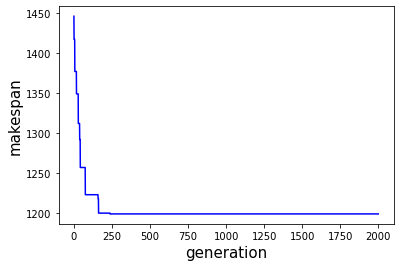

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 13 17:24:51 2018

Author: cheng-man wu
LinkedIn: www.linkedin.com/in/chengmanwu
Github: https://github.com/wurmen

"""

'''==========Solving job shop scheduling problem by gentic algorithm in python======='''
# importing required modules
import pandas as pd
import numpy as np
import time
import copy

''' ================= initialization setting ======================'''


pt_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Processing Time",index_col =[0])
ms_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Machines Sequence",index_col =[0])

dfshape=pt_tmp.shape
num_mc=dfshape[1] # number of machines
num_job=dfshape[0] # number of jobs
num_gene=num_mc*num_job # number of genes in a chromosome

pt=[list(map(int, pt_tmp.iloc[i])) for i in range(num_job)]
ms=[list(map(int,ms_tmp.iloc[i])) for i in range(num_job)]




# raw_input is used in python 2
population_size=int(input('Please input the size of population: ') or 30) # default value is 30
crossover_rate=float(input('Please input the size of Crossover Rate: ') or 0.8) # default value is 0.8
mutation_rate=float(input('Please input the size of Mutation Rate: ') or 0.2) # default value is 0.2
mutation_selection_rate=float(input('Please input the mutation selection rate: ') or 0.2)
num_mutation_jobs=round(num_gene*mutation_selection_rate)
num_iteration=int(input('Please input number of iteration: ') or 2000) # default value is 2000
    
start_time = time.time()

'''==================== main code ==============================='''
'''----- generate initial population -----'''
Tbest=999999999999999
best_list,best_obj=[],[]
population_list=[]
makespan_record=[]
for i in range(population_size):
    nxm_random_num=list(np.random.permutation(num_gene)) # generate a random permutation of 0 to num_job*num_mc-1
    population_list.append(nxm_random_num) # add to the population_list
    for j in range(num_gene):
        population_list[i][j]=population_list[i][j]%num_job # convert to job number format, every job appears m times
        
for n in range(num_iteration):
    Tbest_now=99999999999           
   
    '''-------- two point crossover --------'''
    parent_list=copy.deepcopy(population_list)
    offspring_list=copy.deepcopy(population_list)
    S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover
    
    for m in range(int(population_size/2)):
        crossover_prob=np.random.rand()
        if crossover_rate>=crossover_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]
            child_1=parent_1[:]
            child_2=parent_2[:]
            cutpoint=list(np.random.choice(num_gene, 2, replace=False))
            cutpoint.sort()
        
            child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
            offspring_list[S[2*m]]=child_1[:]
            offspring_list[S[2*m+1]]=child_2[:]
        
    
    '''----------repairment-------------'''
    for m in range(population_size):
        job_count={}
        larger,less=[],[] # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
        for i in range(num_job):
            if i in offspring_list[m]:
                count=offspring_list[m].count(i)
                pos=offspring_list[m].index(i)
                job_count[i]=[count,pos] # store the above two values to the job_count dictionary
            else:
                count=0
                job_count[i]=[count,0]
            if count>num_mc:
                larger.append(i)
            elif count<num_mc:
                less.append(i)
                
        for k in range(len(larger)):
            chg_job=larger[k]
            while job_count[chg_job][0]>num_mc:
                for d in range(len(less)):
                    if job_count[less[d]][0]<num_mc:                    
                        offspring_list[m][job_count[chg_job][1]]=less[d]
                        job_count[chg_job][1]=offspring_list[m].index(chg_job)
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        job_count[less[d]][0]=job_count[less[d]][0]+1                    
                    if job_count[chg_job][0]==num_mc:
                        break     
    
    '''--------mutatuon--------'''   
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if mutation_rate >= mutation_prob:
            m_chg=list(np.random.choice(num_gene, num_mutation_jobs, replace=False)) # chooses the position to mutation
            t_value_last=offspring_list[m][m_chg[0]] # save the value which is on the first mutation position
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last # move the value of the first mutation position to the last mutation position
  
    
    '''--------fitness value(calculate makespan)-------------'''
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) # parent and offspring chromosomes combination
    chrom_fitness,chrom_fit=[],[]
    total_fitness=0
    for m in range(population_size*2):
        j_keys=[j for j in range(num_job)]
        key_count={key:0 for key in j_keys}
        j_count={key:0 for key in j_keys}
        m_keys=[j+1 for j in range(num_mc)]
        m_count={key:0 for key in m_keys}
        
        for i in total_chromosome[m]:
            gen_t=int(pt[i][key_count[i]])
            gen_m=int(ms[i][key_count[i]])
            j_count[i]=j_count[i]+gen_t
            m_count[gen_m]=m_count[gen_m]+gen_t
            
            if m_count[gen_m]<j_count[i]:
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]:
                j_count[i]=m_count[gen_m]
            
            key_count[i]=key_count[i]+1
    
        makespan=max(j_count.values())
        chrom_fitness.append(1/makespan)
        chrom_fit.append(makespan)
        total_fitness=total_fitness+chrom_fitness[m]

    
    '''----------selection(roulette wheel approach)----------'''
    pk,qk=[],[]
    
    for i in range(population_size*2):
        pk.append(chrom_fitness[i]/total_fitness)
    for i in range(population_size*2):
        cumulative=0
        for j in range(0,i+1):
            cumulative=cumulative+pk[j]
        qk.append(cumulative)
    
    selection_rand=[np.random.rand() for i in range(population_size)]
    
    for i in range(population_size):
        if selection_rand[i]<=qk[0]:
            population_list[i]=copy.deepcopy(total_chromosome[0])
        else:
            for j in range(0,population_size*2-1):
                if selection_rand[i]>qk[j] and selection_rand[i]<=qk[j+1]:
                    population_list[i]=copy.deepcopy(total_chromosome[j+1])
                    break
    '''----------comparison----------'''
    for i in range(population_size*2):
        if chrom_fit[i]<Tbest_now:
            Tbest_now=chrom_fit[i]
            sequence_now=copy.deepcopy(total_chromosome[i])
    if Tbest_now<=Tbest:
        Tbest=Tbest_now
        sequence_best=copy.deepcopy(sequence_now)
        
    makespan_record.append(Tbest)
'''----------result----------'''
print("optimal sequence",sequence_best)
print("optimal value:%f"%Tbest)
print('the elapsed time:%s'% (time.time() - start_time))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([i for i in range(len(makespan_record))],makespan_record,'b')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('generation',fontsize=15)
plt.show()


In [15]:
'''--------plot gantt chart-------'''
import pandas as pd
import chart_studio.plotly as py            ## Revise
import chart_studio                         ## Add
import plotly.figure_factory as ff
import datetime

chart_studio.tools.set_credentials_file(username='LCJ', api_key='MXyqUZQn59PkwA2IfY2W')   ## Add

m_keys=[j+1 for j in range(num_mc)]
#print(m_keys) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 機器數
j_keys=[j for j in range(num_job)]
#print(j_keys) #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 工作數


key_count={key:0 for key in j_keys}
#print(key_count) #{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
j_count={key:0 for key in j_keys}
#print(j_count) #{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
m_count={key:0 for key in m_keys}
#print(m_count) #{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}


for i in sequence_best:
    gen_t=int(pt[i][key_count[i]])
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t
    m_count[gen_m]=m_count[gen_m]+gen_t
    
    if m_count[gen_m]<j_count[i]:
        m_count[gen_m]=j_count[i]
    elif m_count[gen_m]>j_count[i]:
        j_count[i]=m_count[gen_m]

    #print(pt[i][key_count[i]])  # 46、76、81、37...
    print(datetime.timedelta(seconds=76))
    start_time=str(datetime.timedelta(seconds=j_count[i]-pt[i][key_count[i]])) # convert seconds to hours, minutes and seconds
    #76>>0:01:16.... 用秒來表示
    end_time=str(datetime.timedelta(seconds=j_count[i]))
        
    j_record[(i,gen_m)]=[start_time,end_time]
    
    key_count[i]=key_count[i]+1

#print(j_record)  #{(6, 2): ['0:00:00', '0:00:46'], (8, 1): ['0:00:00', '0:01:16'],.......
#print(key_count)  #{0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10}

df=[]
for m in m_keys:
    for j in j_keys:
        df.append(dict(Task='Machine %s'%(m), Start='2018-07-14 %s'%(str(j_record[(j,m)][0])), Finish='2018-07-14 %s'%(str(j_record[(j,m)][1])),Resource='Job %s'%(j+1)))
# {'Task': 'Machine 1', 'Start': '2018-07-14 0:06:53', 'Finish': '2018-07-14 0:07:22', 'Resource': 'Job 1'}   

fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
##py.iplot(fig, filename='GA_job_shop_scheduling', world_readable=True) #先註解掉
#print(df)





0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16
0:01:16


In [32]:
import plotly.express as px
import pandas as pd


M1Answer=[(4, 0, 78), (8, 78, 89), (1, 89, 169), (6, 169, 181)]
M2Answer=[(7, 0, 99), (2, 99, 185), (5, 185, 263)]
M3Answer=[(3, 0, 96), (9, 96, 141), (10, 141, 162)]

## 會用到%%
df=[]
#M1
for i in range(len(M1Answer)):
    df.append(dict(Task='Job %s'%M1Answer[i][0], Start='2018-07-14 %s'%datetime.timedelta(seconds=M1Answer[i][1]), Finish='2018-07-14 %s'%datetime.timedelta(seconds=M1Answer[i][2]),Resource='Machine 1'))

for i in range(len(M2Answer)):
    df.append(dict(Task='Job %s'%M2Answer[i][0], Start='2018-07-14 %s'%datetime.timedelta(seconds=M2Answer[i][1]), Finish='2018-07-14 %s'%datetime.timedelta(seconds=M2Answer[i][2]),Resource='Machine 2'))

for i in range(len(M3Answer)):
    df.append(dict(Task='Job %s'%M3Answer[i][0], Start='2018-07-14 %s'%datetime.timedelta(seconds=M3Answer[i][1]), Finish='2018-07-14 %s'%datetime.timedelta(seconds=M3Answer[i][2]),Resource='Machine 3'))
'''
df = pd.DataFrame([
    dict(Task="Job A", Start='2009-01-01', Finish='2009-02-28', Resource="Alex"),
    dict(Task="Job B", Start='2009-03-05', Finish='2009-04-15', Resource="Alex"),
    dict(Task="Job C", Start='2009-02-20', Finish='2009-05-30', Resource="Max")
])
'''
fig = px.timeline(df, x_start="Start", x_end="Finish", y="Resource", color="Task")
fig.show()

In [35]:
M1Answer=[(4, 0, 78), (8, 78, 89), (1, 89, 169), (6, 169, 181)]
#print(M1Answer[0][2])

for i in range(len(M1Answer)):
    print(M1Answer[i][1])


0
78
89
169


In [11]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 15 19:31:08 2020

@author: admin
"""
#步驟一
#將每個Job 亂數指派到Machine 1~3之一

#工件機器限制 K
MachineLimit=[[1,0,1],[1,1,1],[1,0,1],[1,1,1],[1,1,0],
              [1,0,1],[1,1,1],[1,0,1],[0,1,1],[1,1,1]]

#工作時間
Processtime=[[80,0,60],[75,86,94],[25,0,96],[78,95,89],[45,78,0],
              [12,0,65],[55,99,87],[11,0,16],[0,16,45],[43,56,21]]


#指派機器Function
def GetMachineNumber(MachineLimit):

    #選機隨機碼
    import random
    SelectJobCode=random.random() #0~1亂數
    #單份機率
    sum = 0
    for i in MachineLimit:
        sum += i
    PJ1 =1/sum
    #決定是第幾份(k)
    k=1 #<預設為第一份>
    TotalPJ1=PJ1
    while(SelectJobCode>TotalPJ1):
        k+=1
        TotalPJ1=PJ1*k

    #print(k)

    #工作派給機器(j)
    FinalMachineJ1=0
    sequence=[0,1,2] #機1.2.3
    for j in sequence:
        if(MachineLimit[j]==1):
            k-=1
        if(k==0):
            FinalMachineJ1=j+1 #加回來
            break
    return FinalMachineJ1

##(呼叫Function)指派10工件給3機
JobResult=[]
for s in MachineLimit:
    JobResult.append(GetMachineNumber(s)) #參數 工件一:[1,0,1]...

#分類依機台
MachineNumber=1
M1=[]
M2=[]
M3=[]
for w in JobResult:
    if(w==1):
        M1.append(MachineNumber)
    elif(w==2):
        M2.append(MachineNumber)
    else:
        M3.append(MachineNumber)
    MachineNumber+=1
print("步驟一")
print(M1)
print(M2)
print(M3)

#步驟二
#決定每個Job在三個機台中的先後順序

#產生順序隨機碼，進行排序
import random
OrderJobM1=[]
OrderJobM2=[]
OrderJobM3=[]
for x in range(len(M1)):
    OrderJobM1.append(random.random())
cM1 = list(zip(M1,OrderJobM1))  #兩個一維轉成一個二維
nM1=sorted(cM1,key=(lambda x:x[1]),reverse=True) #二維排序(x[1]針對欄位二) 由大到小
#print(nM1)  #排序結果
for x in range(len(M2)):
    OrderJobM2.append(random.random())
cM2 = list(zip(M2,OrderJobM2))  #兩個一維轉成一個二維
nM2=sorted(cM2,key=(lambda x:x[1]),reverse=True) #二維排序
#print(nM2)  #排序結果

for x in range(len(M3)):
    OrderJobM3.append(random.random())
cM3 = list(zip(M3,OrderJobM3))  #兩個一維轉成一個二維
nM3=sorted(cM3,key=(lambda x:x[1]),reverse=True) #二維排序
#print(nM3)  #排序結果

print("步驟二")
# 只取出排序後的工件欄位(nnM?)
nnM1=[]
for a in range(len(nM1)):
   # print(nM1[a][0]) >> Job幾
    nnM1.append(nM1[a][0])
print(nnM1)
nnM2=[]
 # 工作順序
for a in range(len(nM2)):
   # print(nM1[a][0]) >> Job幾
    nnM2.append(nM2[a][0])
print(nnM2)

nnM3=[]
 # 工作順序
for a in range(len(nM3)):
   # print(nM1[a][0]) >> Job幾
    nnM3.append(nM3[a][0])
print(nnM3)



#步驟三
#計算每個Job的開始與結束時間
print("步驟三")
###---------M1-------

# 開始時間
M1t=0
M1StartAnswer=M1t
M1StartT=[]
M1StartT.append(M1t)
for b in range(len(nnM1)-1):
   # M1StartT.append(Processtime[nnM1[b]-1][0])
    M1StartAnswer+=Processtime[nnM1[b]-1][0]
    M1StartT.append(M1StartAnswer)

# 結束時間
M1EndAnswer=M1t
M1EndT=[]
for b in range(len(nnM1)):
   # M1StartT.append(Processtime[nnM1[b]-1][0])
    M1EndAnswer+=Processtime[nnM1[b]-1][0]   #0 [80,0,60] 取第一個欄位
    M1EndT.append(M1EndAnswer)
# 合併
M1Answer = list(zip(nnM1,M1StartT,M1EndT))
print(M1Answer)


###---------M2-------


# 開始時間
M2t=0
M2StartAnswer=M2t
M2StartT=[]
M2StartT.append(M2t)
for b in range(len(nnM2)-1):
   # M1StartT.append(Processtime[nnM1[b]-1][0])
    M2StartAnswer+=Processtime[nnM2[b]-1][1]    #1 [80,0,60] 取第二個欄位
    M2StartT.append(M2StartAnswer)

# 結束時間
M2EndAnswer=M2t
M2EndT=[]
for b in range(len(nnM2)):
   # M1StartT.append(Processtime[nnM1[b]-1][0])
    M2EndAnswer+=Processtime[nnM2[b]-1][1]
    M2EndT.append(M2EndAnswer)
# 合併
M2Answer = list(zip(nnM2,M2StartT,M2EndT))
print(M2Answer)

###---------M3-------


# 開始時間
M3t=0
M3StartAnswer=M3t
M3StartT=[]
M3StartT.append(M3t)
for b in range(len(nnM3)-1):
   # M1StartT.append(Processtime[nnM1[b]-1][0])
    M3StartAnswer+=Processtime[nnM3[b]-1][2]    #2 [80,0,60] 取第三個欄位
    M3StartT.append(M3StartAnswer)

# 結束時間
M3EndAnswer=M3t
M3EndT=[]
for b in range(len(nnM3)):
   # M1StartT.append(Processtime[nnM1[b]-1][0])
    M3EndAnswer+=Processtime[nnM3[b]-1][2]
    M3EndT.append(M3EndAnswer)
# 合併
M3Answer = list(zip(nnM3,M3StartT,M3EndT))
print(M3Answer)

#-------Makespan----------
'''
if(M1Answer>M2Answer and M1Answer>M3Answer):
    print("M1"+" "+ str(M1Answer))
elif(M2Answer>M1Answer and M2Answer>M3Answer):
    print("M2"+" "+ str(M2Answer))
else:
    print("M3"+" "+ str(M3Answer))
'''


## Gantt

import plotly.express as px
import pandas as pd
import datetime

## 會用到%%
df=[]
#M1
for i in range(len(M1Answer)):
    df.append(dict(Task='Job %s'%M1Answer[i][0], Start='2018-07-14 %s'%datetime.timedelta(seconds=M1Answer[i][1]), Finish='2018-07-14 %s'%datetime.timedelta(seconds=M1Answer[i][2]),Resource='Machine 1'))

for i in range(len(M2Answer)):
    df.append(dict(Task='Job %s'%M2Answer[i][0], Start='2018-07-14 %s'%datetime.timedelta(seconds=M2Answer[i][1]), Finish='2018-07-14 %s'%datetime.timedelta(seconds=M2Answer[i][2]),Resource='Machine 2'))

for i in range(len(M3Answer)):
    df.append(dict(Task='Job %s'%M3Answer[i][0], Start='2018-07-14 %s'%datetime.timedelta(seconds=M3Answer[i][1]), Finish='2018-07-14 %s'%datetime.timedelta(seconds=M3Answer[i][2]),Resource='Machine 3'))
'''
df = pd.DataFrame([
    dict(Task="Job A", Start='2009-01-01', Finish='2009-02-28', Resource="Alex"),
    dict(Task="Job B", Start='2009-03-05', Finish='2009-04-15', Resource="Alex"),
    dict(Task="Job C", Start='2009-02-20', Finish='2009-05-30', Resource="Max")
])
'''
fig = px.timeline(df, x_start="Start", x_end="Finish", y="Resource", color="Task")
fig.show()

步驟一
[1, 3, 6, 8]
[2, 4, 5, 9]
[7, 10]
步驟二
[1, 3, 6, 8]
[5, 2, 9, 4]
[7, 10]
步驟三
[(1, 0, 80), (3, 80, 105), (6, 105, 117), (8, 117, 128)]
[(5, 0, 78), (2, 78, 164), (9, 164, 180), (4, 180, 275)]
[(7, 0, 87), (10, 87, 108)]
